In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
file_path = '/content/train_u6lujuX_CVtuZ9i.csv'
data = pd.read_csv(file_path)

# Handling missing values
categorical_columns = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

numerical_columns = ['LoanAmount', 'Loan_Amount_Term']
for col in numerical_columns:
    data[col].fillna(data[col].median(), inplace=True)

# Applying log transformation to income fields to reduce skewness
data['Log_ApplicantIncome'] = np.log(data['ApplicantIncome'] + 1)
data['Log_CoapplicantIncome'] = np.log(data['CoapplicantIncome'] + 1)
data['Log_LoanAmount'] = np.log(data['LoanAmount'] + 1)


<ipython-input-2-9e5daea6b9eb>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mode()[0], inplace=True)
<ipython-input-2-9e5daea6b9eb>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try u

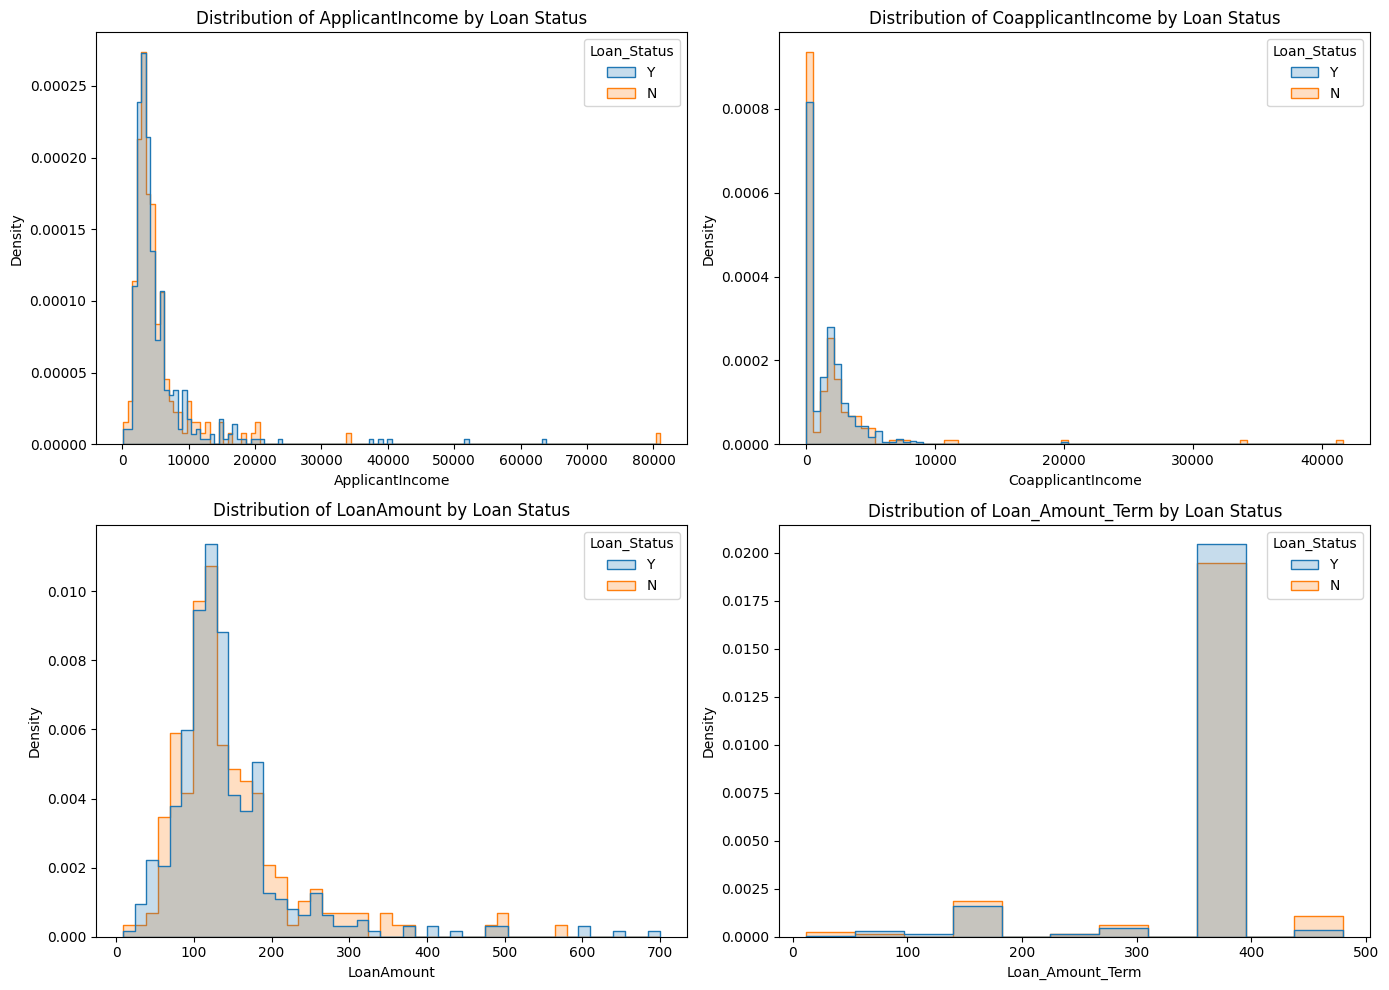

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(14, 10))

# Histograms of numerical features by Loan Status
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(data=data, x=col, hue="Loan_Status", element="step", stat="density", common_norm=False)
    plt.title(f'Distribution of {col} by Loan Status')

plt.tight_layout()
plt.show()


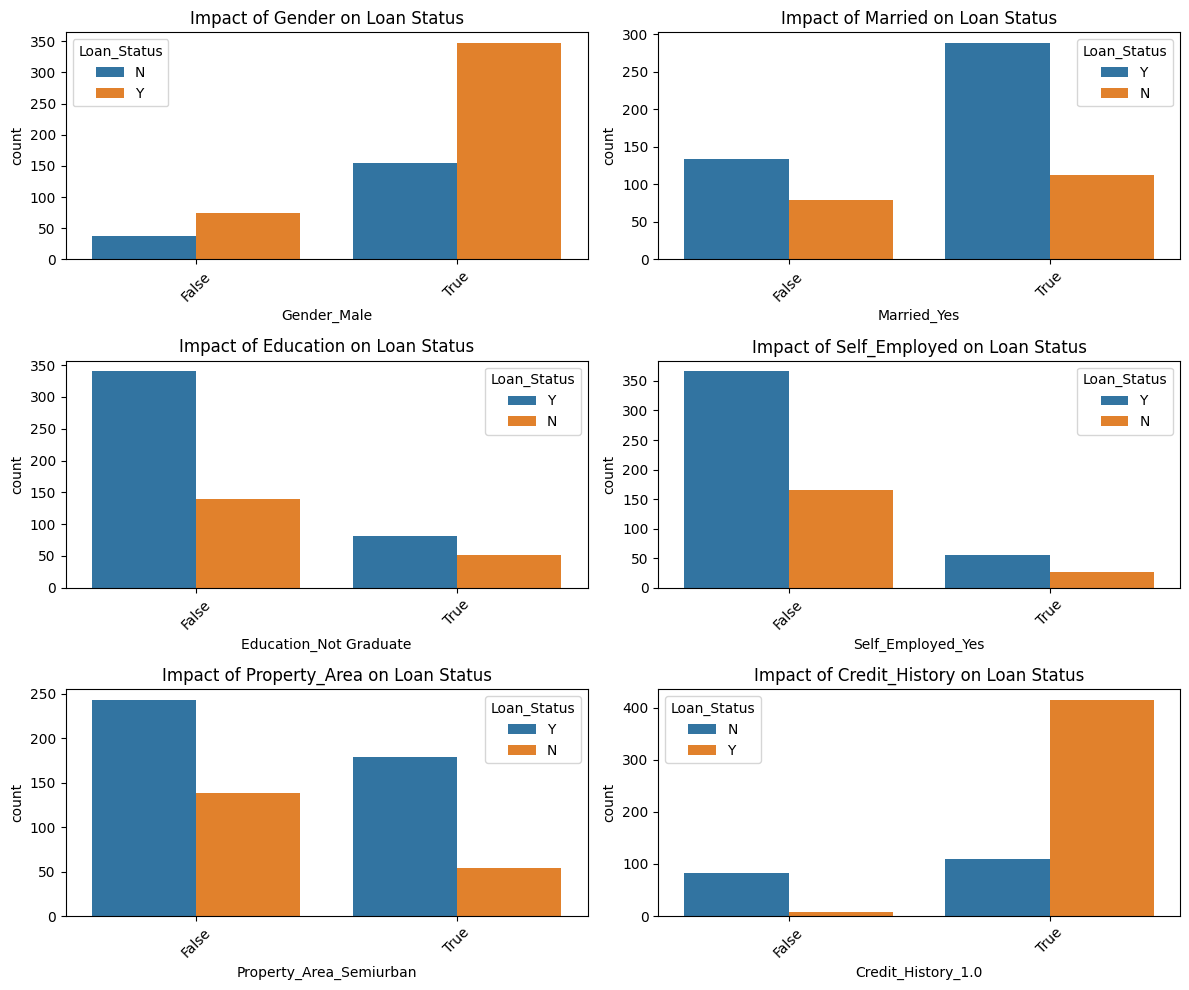

In [20]:
# Impact of Categorical Features on Loan Status
categorical_features = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']

plt.figure(figsize=(12, 10))
for i, col in enumerate(categorical_features):
    plt.subplot(3, 2, i + 1)
    # Use the encoded column names instead of original column names
    encoded_col = [c for c in data.columns if c.startswith(col + '_')][0]  # Get the first encoded column
    sns.countplot(data=data, x=encoded_col, hue='Loan_Status')
    plt.title(f'Impact of {col} on Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Feature engineering
data['Total_Income'] = data['ApplicantIncome'] + data['CoapplicantIncome']
data['Income_Loan_Ratio'] = data['Total_Income'] / data['LoanAmount']
data['Log_Total_Income'] = np.log(data['Total_Income'] + 1)

# Standardizing numerical features
scaler = StandardScaler()
scale_columns = ['Log_ApplicantIncome', 'Log_CoapplicantIncome', 'Log_LoanAmount', 'Log_Total_Income', 'Income_Loan_Ratio']
data[scale_columns] = scaler.fit_transform(data[scale_columns])

# Encoding categorical variables
data = pd.get_dummies(data, columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History'], drop_first=True)

# Splitting the data
X = data.drop(columns=['Loan_ID', 'Loan_Status', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Total_Income'])
y = data['Loan_Status'].map({'Y': 1, 'N': 0})  # Binary encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Define base classifiers
clf1 = LogisticRegression(random_state=42)
clf2 = SVC(probability=True, random_state=42)
clf3 = DecisionTreeClassifier(random_state=42)

# Max Voting
voting_clf_hard = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('dt', clf3)], voting='hard')
voting_clf_hard.fit(X_train, y_train)
hard_voting_pred = voting_clf_hard.predict(X_test)

# Averaging
voting_clf_soft = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('dt', clf3)], voting='soft')
voting_clf_soft.fit(X_train, y_train)
soft_voting_pred = voting_clf_soft.predict_proba(X_test)[:, 1] > 0.5


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Using a simple Decision Tree as the base estimator
# In older versions of scikit-learn, the parameter was named 'estimator' instead of 'base_estimator'
bagging_clf = BaggingClassifier(
    estimator=DecisionTreeClassifier(random_state=42),  # Changed 'base_estimator' to 'estimator'
    n_estimators=100,
    random_state=42
)
bagging_clf.fit(X_train, y_train)
bagging_pred = bagging_clf.predict(X_test)

In [16]:
import lightgbm as lgb

# LightGBM Classifier
lgbm_clf = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 302, number of negative: 127
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 429, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703963 -> initscore=0.866240
[LightGBM] [Info] Start training from score 0.866240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Using a combination of different algorithms
stacking_clf = StackingClassifier(
    estimators=[('lr', LogisticRegression()), ('dt', DecisionTreeClassifier()), ('svc', SVC())],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

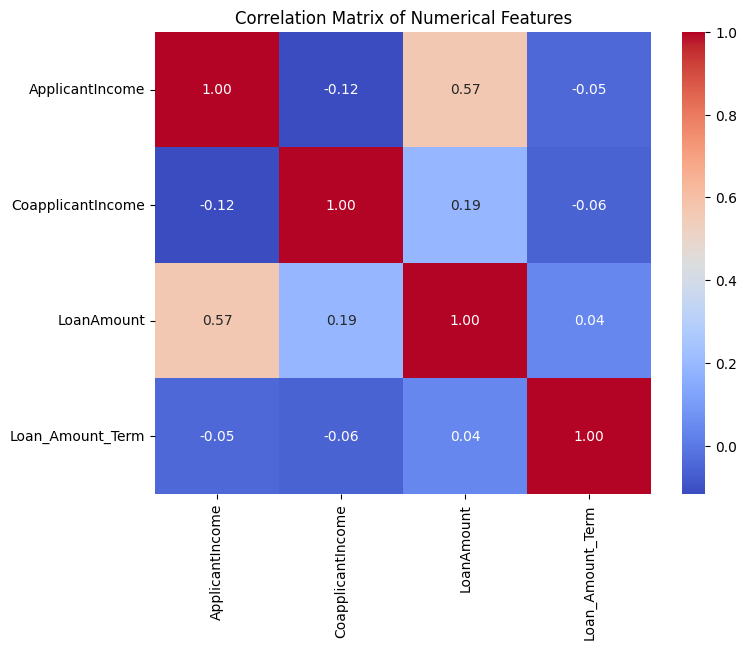

In [21]:
# Correlation matrix
correlation = data[numerical_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()


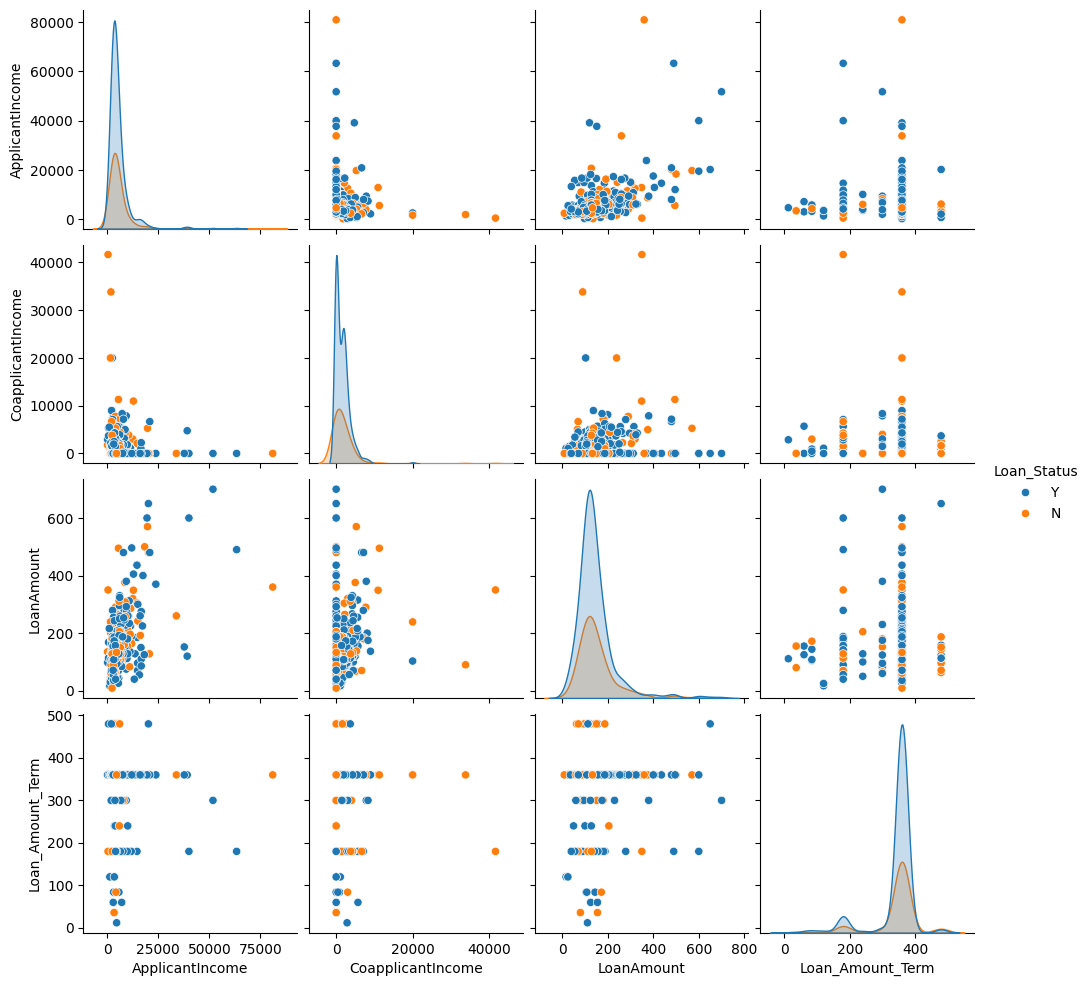

In [23]:
# Pairplot for numerical features
sns.pairplot(data=data, hue='Loan_Status', vars=numerical_features)
plt.show()


In [12]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_clf.fit(X_train, y_train)
rf_pred = random_forest_clf.predict(X_test)


In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gbm_clf.fit(X_train, y_train)
gbm_pred = gbm_clf.predict(X_test)


In [14]:
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xgboost_clf.fit(X_train, y_train)
xgb_pred = xgboost_clf.predict(X_test)


In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ensemble predictions are already defined: bagging_pred, lgbm_pred, stacking_pred, rf_pred, gbm_pred, xgb_pred

methods = ['Bagging', 'LightGBM', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost']
predictions = [bagging_pred, lgbm_pred, stacking_pred, rf_pred, gbm_pred, xgb_pred]

scores_dict = {}
for method, pred in zip(methods, predictions):
    scores_dict[method] = {
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred)
    }

# Convert scores dictionary to DataFrame for better visualization
import pandas as pd
scores_df = pd.DataFrame(scores_dict).T
print(scores_df)


                   Accuracy  Precision    Recall  F1 Score
Bagging            0.783784   0.773973  0.941667  0.849624
LightGBM           0.756757   0.777778  0.875000  0.823529
Stacking           0.778378   0.751592  0.983333  0.851986
Random Forest      0.794595   0.788732  0.933333  0.854962
Gradient Boosting  0.783784   0.770270  0.950000  0.850746
XGBoost            0.800000   0.802920  0.916667  0.856031
